# Project "With Sense"

Мы работаем в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”). 
Наши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 
На основе лучшей модели можно будет собрать предварительную версию продукта, которую мы покажете руководителю компании.

In [ ]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os

import cv2


import torch

from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet') # необходимо для работы WordNetLemmatizer
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

import re
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
DATA_PATH = '/content/to_upload'

data = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))
data_test = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'))
cr_annot = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'),sep='\t', names=['image','query_id','proportion','match_total','mismatch_total'], header=None)
exp_annot = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'),sep='\t', names=['image','query_id','exp_1','exp_2','exp_3'], header=None)
test_quer = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'),sep='|',index_col=0)
test_images = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'))

## Исследуем данные

In [ ]:
data.info()
display(data.head())
unique_images = data['image'].nunique()
unique_queries = data['query_text'].nunique()
print()
print("Уникальное количество фотографий: ", unique_images)
print("Уникальное количество запросов: ", unique_queries)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...


Уникальное количество фотографий:  1000
Уникальное количество запросов:  977


In [ ]:
test_quer.info()
display(test_quer.head())
unique_images = test_quer['image'].nunique()
unique_queries = test_quer['query_text'].nunique()
print()
print("Уникальное количество фотографий: ", unique_images)
print("Уникальное количество запросов: ", unique_queries)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg


Уникальное количество фотографий:  100
Уникальное количество запросов:  500


In [ ]:
print("Краудсорсинговые оценки")
display(cr_annot.info())
print('Кол-во краудсорсинговых оценок = ', cr_annot.shape[0])
print()
print("Оценки экспертов")
exp_annot.info()
print()
print('Кол-во оценок экспертов = ', exp_annot.shape[0])

Краудсорсинговые оценки
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image           47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   proportion      47830 non-null  float64
 3   match_total     47830 non-null  int64  
 4   mismatch_total  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Кол-во краудсорсинговых оценок =  47830

Оценки экспертов
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB

Кол-во оценок экспертов =  5822


In [ ]:
print("Краудсорсинговые оценки")
display(cr_annot.head())
print()
print("Оценки экспертов")
exp_annot.head()

Краудсорсинговые оценки


image                     query_id  proportion  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2         1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2         0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2         0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2         0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2         0.0   

   match_total  mismatch_total  
0            3               0  
1            0               3  
2            0               3  
3            0               3  
4            0               3


Оценки экспертов


image                     query_id  exp_1  exp_2  exp_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1      2

С нашими данными все в порядке, начнем заниматься аггрегацией оценки. Обратим внимание, что краудсорсинговые оценки состоят из пропорции, сколько человек из 3 посчитали фотографию соответствующей запросу, оценки экспертов в свою очередь определяют соответствие фотографии запроса от 1 до 4, независимо друг от друга

In [ ]:
#функция агрегирующая оценку экспертов
def aggregate_score(row):
        # Создаем список оценок для текущей пары изображение-текст
        scores = [row['exp_1'], row['exp_2'], row['exp_3']]

        # Создаем словарь для подсчета количества голосов за каждую оценку
        vote_counts = {}
        for score in scores:
            if score in vote_counts:
                vote_counts[score] += 1
            else:
                vote_counts[score] = 1

        # Ищем оценку, за которую проголосовала большинство экспертов
        max_votes = max(vote_counts.values())
        if max_votes == 1:
            # Все оценки различны, возвращаем None
            return None
        else:
            # Находим список оценок, за которые проголосовало большинство экспертов
            top_scores = [score for score, count in vote_counts.items() if count == max_votes]
            # Возвращаем любую из этих оценок
            return top_scores[0]

In [ ]:
exp_annot['aggregated_score'] = exp_annot.apply(aggregate_score, axis=1)
exp_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             5822 non-null   object 
 1   query_id          5822 non-null   object 
 2   exp_1             5822 non-null   int64  
 3   exp_2             5822 non-null   int64  
 4   exp_3             5822 non-null   int64  
 5   aggregated_score  5696 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 273.0+ KB


Соединим ввсе необходимые нам данные, возьмем с оценки из краудсорсинга пропорцию в качестве оценки

In [ ]:
full_data = pd.merge(cr_annot, exp_annot,  on=['image','query_id'], how='outer')
full_data = pd.merge(full_data, data[['query_text', 'query_id']], on='query_id')
full_data = full_data.drop(['exp_1','exp_2','exp_3','match_total','mismatch_total'], axis=1)
full_data = full_data.drop_duplicates(subset=['image','query_id'], ignore_index=True)
full_data

image                     query_id  proportion  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1.000000   
1      2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2    0.000000   
2      2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2    0.000000   
3      2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2    0.000000   
4      2892995070_39f3c9a56e.jpg  1056338697_4f7d7ce270.jpg#2    0.000000   
...                          ...                          ...         ...   
50209   422763475_0bc814dac6.jpg  3108732084_565b423162.jpg#2    0.333333   
50210    96420612_feb18fc6c6.jpg  3108732084_565b423162.jpg#2    0.000000   
50211  2985679744_75a7102aab.jpg  3108732084_565b423162.jpg#2         NaN   
50212  3745451546_fc8ec70cbd.jpg  3108732084_565b423162.jpg#2         NaN   
50213   447111935_5af98563e3.jpg  3108732084_565b423162.jpg#2         NaN   

       aggregated_score                                         query_text  
0                   NaN  A woman is signaling is to traffic , as seen f...  
1                   NaN  A woman is signaling is to traffic , as seen f...  
2                   NaN  A woman is signaling is to traffic , as seen f...  
3                   NaN  A woman is signaling is to traffic , as seen f...  
4                   NaN  A woman is signaling is to traffic , as seen f...  
...                 ...                                                ...  
50209               NaN                                      a snowboarder  
50210               NaN                                      a snowboarder  
50211               1.0                                      a snowboarder  
50212               1.0                                      a snowboarder  
50213               1.0                                      a snowboarder  

[50214 rows x 5 columns]

Проанализируем наши данные, чтобы решить, как мы получим общую оценку, на которую будем опираться


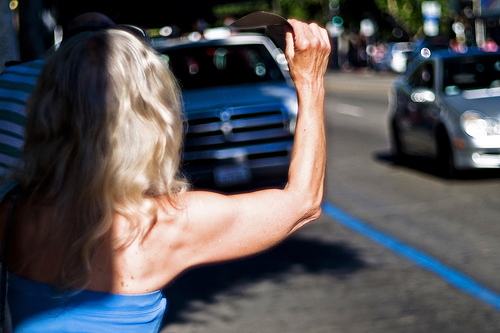

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 1.0


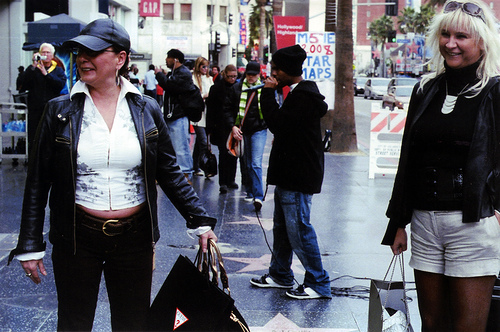

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


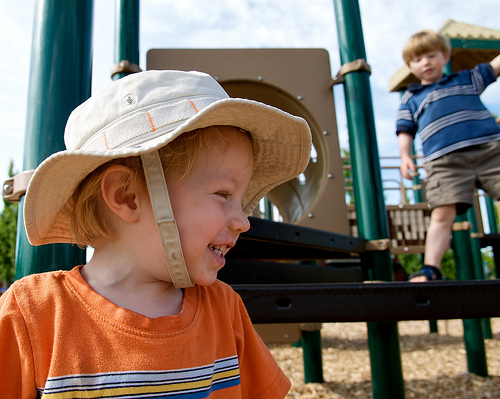

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


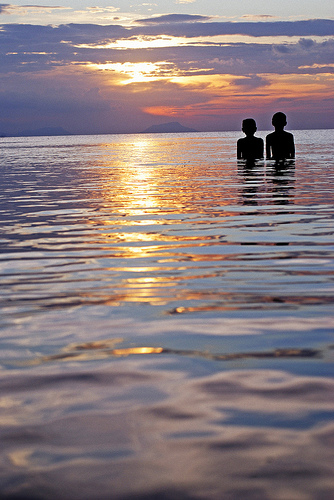

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


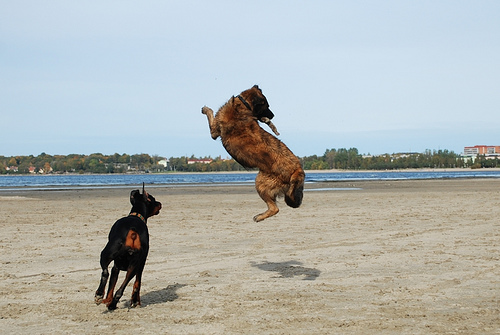

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


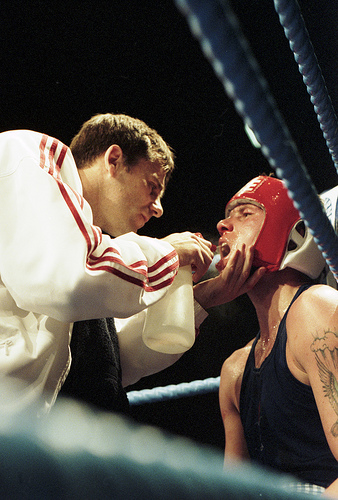

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


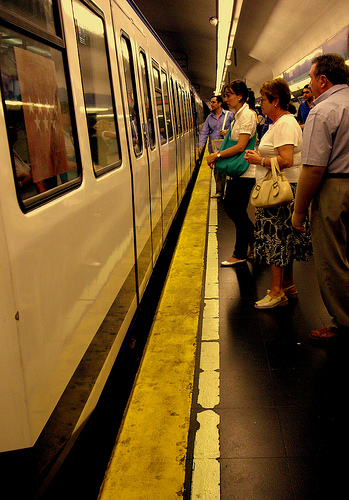

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


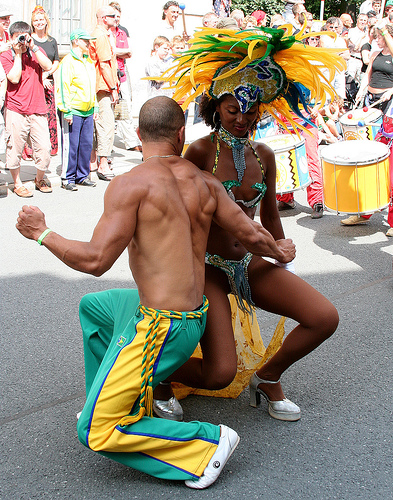

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


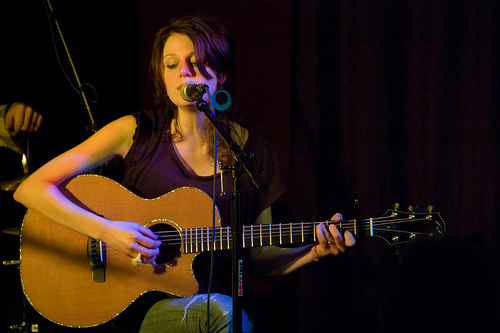

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


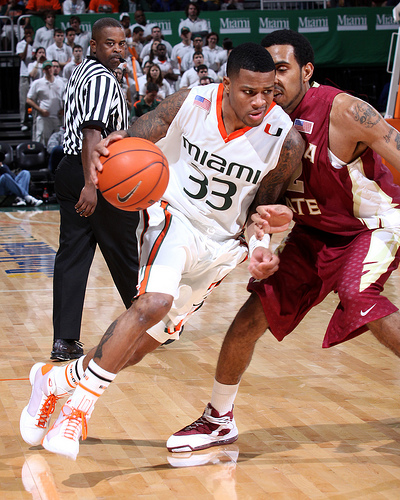

Описание: A woman is signaling is to traffic , as seen from behind .
Оценка экспертов: nan
Оценка crowd: 0.0


In [ ]:
for i in range(0, 10):
    # Загрузка изображения
    img_name = 'train_images/'+ full_data['image'][i]
    img = Image.open(os.path.join(DATA_PATH,img_name))
    #img = Image.open('/content/drive/MyDrive/to_upload/train_images/' + full_data['image'][i])
    # Отображение изображения
    img.show()
    # Вывод описания и оценки
    print('Описание:', full_data['query_text'][i])
    print('Оценка экспертов:', full_data['aggregated_score'][i])
    print('Оценка crowd:', full_data['proportion'][i])

Видим, что оценки экспертов более адекватны, поэтому я буду отдавать им приоритет

In [ ]:
def total_score(row):
  #Приведем оценки экспертов к значениям в диапазоне от 0 до 1, с которыми нам будет удобно взаимодействовать
  score_exp = row['aggregated_score']  
  score_cr = row['proportion']
  if np.isnan(score_exp):
        return score_cr
  elif np.isnan(score_cr):
        return score_exp/4
  else:
        return 0.7 * score_exp/4 + 0.3 * score_cr
  

In [ ]:
full_data['total_score'] = full_data.apply(total_score, axis=1)
full_data.drop(['aggregated_score','proportion',], axis=1, inplace=True)
full_data

image                     query_id  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1      2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   
2      2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2   
3      2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2   
4      2892995070_39f3c9a56e.jpg  1056338697_4f7d7ce270.jpg#2   
...                          ...                          ...   
50209   422763475_0bc814dac6.jpg  3108732084_565b423162.jpg#2   
50210    96420612_feb18fc6c6.jpg  3108732084_565b423162.jpg#2   
50211  2985679744_75a7102aab.jpg  3108732084_565b423162.jpg#2   
50212  3745451546_fc8ec70cbd.jpg  3108732084_565b423162.jpg#2   
50213   447111935_5af98563e3.jpg  3108732084_565b423162.jpg#2   

                                              query_text  total_score  
0      A woman is signaling is to traffic , as seen f...     1.000000  
1      A woman is signaling is to traffic , as seen f...     0.000000  
2      A woman is signaling is to traffic , as seen f...     0.000000  
3      A woman is signaling is to traffic , as seen f...     0.000000  
4      A woman is signaling is to traffic , as seen f...     0.000000  
...                                                  ...          ...  
50209                                      a snowboarder     0.333333  
50210                                      a snowboarder     0.000000  
50211                                      a snowboarder     0.250000  
50212                                      a snowboarder     0.250000  
50213                                      a snowboarder     0.250000  

[50214 rows x 4 columns]

## Предобработка данных

Создадим список запретных слов, чтобы избавиться от возможности юридических проблем

In [ ]:
zapretki = ['child', 'young', 'little', 'boy', 'girl', 'kid']
bad_query_ids = []

for index, row in full_data.iterrows():
    if any(word in row['query_text'] for word in zapretki):
        bad_query_ids.append(row['query_id'])

bad_image_names = [q_id[:-2] for q_id in bad_query_ids] 

data_filtered = full_data[~full_data['query_id'].isin(bad_query_ids)]   
data_filtered = data_filtered[~full_data['image'].isin(bad_image_names)]    
data_filtered = data_filtered.reset_index(drop=True)
data_filtered = data_filtered.drop('query_id', axis=1)
data_filtered   

<ipython-input-63-514f4a386ac3>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_filtered = data_filtered[~full_data['image'].isin(bad_image_names)]


image  \
0      1056338697_4f7d7ce270.jpg   
1      2182488373_df73c7cc09.jpg   
2      2843695880_eeea6c67db.jpg   
3      2892995070_39f3c9a56e.jpg   
4      2934359101_cdf57442dc.jpg   
...                          ...   
29079  3364026240_645d533fda.jpg   
29080    96420612_feb18fc6c6.jpg   
29081  2985679744_75a7102aab.jpg   
29082  3745451546_fc8ec70cbd.jpg   
29083   447111935_5af98563e3.jpg   

                                              query_text  total_score  
0      A woman is signaling is to traffic , as seen f...     1.000000  
1      A woman is signaling is to traffic , as seen f...     0.000000  
2      A woman is signaling is to traffic , as seen f...     0.000000  
3      A woman is signaling is to traffic , as seen f...     0.000000  
4      A woman is signaling is to traffic , as seen f...     0.000000  
...                                                  ...          ...  
29079                                      a snowboarder     0.333333  
29080                                      a snowboarder     0.000000  
29081                                      a snowboarder     0.250000  
29082                                      a snowboarder     0.250000  
29083                                      a snowboarder     0.250000  

[29084 rows x 3 columns]

Далее лемматизируем, а впоследствии векторизуем текст

In [ ]:
import pymystem3
m = pymystem3.Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from pymystem3 import Mystem
m = Mystem()

In [ ]:
def lemmatize_1(text):
    lemmatizer = WordNetLemmatizer()


    # токенизируем текст на отдельные слова
    words = word_tokenize(text)

    # лемматизируем каждое слово
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    lemmatized_text = " ".join(lemmatized_words)
    
    return re.sub(r'[^\w\s]', '', lemmatized_text)
    
    # выводим результаты

In [ ]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()


    # токенизируем текст на отдельные слова
    words = word_tokenize(text)

    # лемматизируем каждое слово
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    lemmatized_text = " ".join(lemmatized_words)
    
    return re.sub(r'[^\w\s]', '', lemmatized_text)
    
    # выводим результаты
    

In [ ]:
data_filtered.loc[:, 'lemm_text'] = data_filtered['query_text'].apply(lemmatize)
data_filtered.reset_index(drop=True, inplace=True)
data_filtered

image  \
0      1056338697_4f7d7ce270.jpg   
1      2182488373_df73c7cc09.jpg   
2      2843695880_eeea6c67db.jpg   
3      2892995070_39f3c9a56e.jpg   
4      2934359101_cdf57442dc.jpg   
...                          ...   
29079  3364026240_645d533fda.jpg   
29080    96420612_feb18fc6c6.jpg   
29081  2985679744_75a7102aab.jpg   
29082  3745451546_fc8ec70cbd.jpg   
29083   447111935_5af98563e3.jpg   

                                              query_text  total_score  \
0      A woman is signaling is to traffic , as seen f...     1.000000   
1      A woman is signaling is to traffic , as seen f...     0.000000   
2      A woman is signaling is to traffic , as seen f...     0.000000   
3      A woman is signaling is to traffic , as seen f...     0.000000   
4      A woman is signaling is to traffic , as seen f...     0.000000   
...                                                  ...          ...   
29079                                      a snowboarder     0.333333   
29080                                      a snowboarder     0.000000   
29081                                      a snowboarder     0.250000   
29082                                      a snowboarder     0.250000   
29083                                      a snowboarder     0.250000   

                                               lemm_text  
0      A woman is signaling is to traffic  a seen fro...  
1      A woman is signaling is to traffic  a seen fro...  
2      A woman is signaling is to traffic  a seen fro...  
3      A woman is signaling is to traffic  a seen fro...  
4      A woman is signaling is to traffic  a seen fro...  
...                                                  ...  
29079                                      a snowboarder  
29080                                      a snowboarder  
29081                                      a snowboarder  
29082                                      a snowboarder  
29083                                      a snowboarder  

[29084 rows x 4 columns]

Заранее разделим наш текст на обучающую и валидационные выборки

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=data_filtered.drop(columns=['total_score']), y=data_filtered['total_score'], groups=data_filtered['image']))
train_df, test_df = data_filtered.loc[train_indices], data_filtered.loc[test_indices]

Векторизуем текст

In [ ]:
corpus_train = train_df['lemm_text'].values.astype('U')
count_tf_idf = TfidfVectorizer(stop_words='english') 
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
print("Размер матрицы:", tf_idf_train.shape)

corpus_test = test_df['lemm_text'].values.astype('U')
tf_idf_test = count_tf_idf.transform(corpus_test)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (19986, 1027)
Размер матрицы: (9098, 1027)


Приступим к векторизации изображений

In [ ]:
# Создаем генератор для аугментации изображений и предварительной обработки
data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Создаем генератор для чтения данных из директории с изображениями
data_dir = DATA_PATH + '/train_images'
batch_size = 32


data_loader_train = data_generator.flow_from_dataframe(
    dataframe=train_df[['image','total_score']],
    directory=data_dir,
    x_col='image',
    y_col='total_score',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='raw',
    subset='training',
    shuffle=False  # Установите False, чтобы сохранить порядок файлов
)


data_loader_test = data_generator.flow_from_dataframe(
    dataframe=test_df[['image','total_score']],
    directory=data_dir,
    x_col='image',
    y_col='total_score',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='raw',
    #subset='validation',
    shuffle=False  # Установите False, чтобы сохранить порядок файлов
)

Found 19986 validated image filenames.
Found 9098 validated image filenames.


Векторизуем их с помощью ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
import tensorflow as tf
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Тут у тебя какая-то смесь с торчом (device) и чистого тензорфлоу.
    
Как правило оба фрейморка редко используются в одном проекте, т.к. поддержка обоих фрейворков в проде будет ужас-ужас.
    
Проверить есть ли у тебя видеокарта можно простой командой
    
   !nvidia-smi 

При наличии видеокарты в системе ты увидешь инфоомацию о ней.
    
А менеджеры конекста для керас не нужны. При наличии в системе GPU он будет использован автоматически.
    
</div>

In [ ]:
with tf.device('/device:GPU:0'):
  pred_vectors_train = resnet.predict_generator(data_loader_train, steps=data_loader_train.samples // data_loader_train.batch_size)
  vector_df_train = pd.DataFrame(pred_vectors_train)

<ipython-input-80-e042d379271b>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_vectors_train = resnet.predict_generator(data_loader_train, steps=data_loader_train.samples // data_loader_train.batch_size)


In [ ]:
with tf.device('/device:GPU:0'):
  pred_vectors_test = resnet.predict_generator(data_loader_test, steps=data_loader_test.samples // data_loader_test.batch_size)
  vector_df_test = pd.DataFrame(pred_vectors_test)

<ipython-input-81-1cbd2d865e61>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_vectors_test = resnet.predict_generator(data_loader_test, steps=data_loader_test.samples // data_loader_test.batch_size)


Создадим 2 датасета со всеми екторизованными изображениями

In [ ]:
train_tf = pd.DataFrame(tf_idf_train.toarray())
train_tf['total_score'] = train_df['total_score'].values
train_tf = train_tf.head(vector_df_train.shape[0])
display(train_tf)

test_tf = pd.DataFrame(tf_idf_test.toarray())
test_tf['total_score'] = test_df['total_score'].values
test_tf = test_tf.head(vector_df_test.shape[0])
test_tf

0    1    2    3    4    5    6    7    8    9  ...  1018  1019  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
19963  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
19964  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
19965  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
19966  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
19967  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   

       1020  1021  1022  1023  1024  1025  1026  total_score  
0       0.0   0.0   0.0   0.0   0.0   0.0   0.0         1.00  
1       0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.00  
2       0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.00  
3       0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.00  
4       0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.00  
...     ...   ...   ...   ...   ...   ...   ...          ...  
19963   0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.00  
19964   0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.25  
19965   0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.25  
19966   0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.00  
19967   0.0   0.0   0.0   0.0   0.0   0.0   0.0         0.00  

[19968 rows x 1028 columns]

0    1    2    3    4    5    6    7    8    9  ...  1018  1019  1020  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
9083  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
9084  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
9085  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
9086  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
9087  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

      1021  1022  1023  1024  1025  1026  total_score  
0      0.0   0.0   0.0   0.0   0.0   0.0          0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0          0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0          0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0          0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0          0.0  
...    ...   ...   ...   ...   ...   ...          ...  
9083   0.0   0.0   0.0   0.0   0.0   0.0          0.0  
9084   0.0   0.0   0.0   0.0   0.0   0.0          0.0  
9085   0.0   0.0   0.0   0.0   0.0   0.0          0.0  
9086   0.0   0.0   0.0   0.0   0.0   0.0          0.0  
9087   0.0   0.0   0.0   0.0   0.0   0.0          0.0  

[9088 rows x 1028 columns]

## Обучение модели

Для решения нашей задачи можно использовать метрику Mean Squared Error (MSE).
В данном случае, модель должна предсказывать векторизированное изображение на основе текстового описания. И MSE позволяет измерить, насколько близко предсказанное изображение к истинному.

При использовании MSE в обучении, модель будет стремиться минимизировать среднеквадратичное отклонение между предсказанными и истинными значениями, что поможет улучшить качество предсказаний.

нейронная сеть принимает на вход два вектора: векторизированное изображение и If-idf векторизированный текст. Какую метрику использовать в обучении и почему?

In [ ]:
train_tf.describe()

0             1             2             3             4  \
count  19968.000000  19968.000000  19968.000000  19968.000000  19968.000000   
mean       0.000534      0.000356      0.000558      0.000850      0.000311   
std        0.016094      0.012192      0.016445      0.024498      0.012192   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.485117      0.418003      0.484812      0.707049      0.477970   

                  5             6             7             8             9  \
count  19968.000000  19968.000000  19968.000000  19968.000000  19968.000000   
mean       0.001066      0.000258      0.000396      0.000752      0.000488   
std        0.024736      0.010092      0.014444      0.018846      0.014384   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.575150      0.395641      0.527185      0.561753      0.424051   

       ...          1018          1019          1020          1021  \
count  ...  19968.000000  19968.000000  19968.000000  19968.000000   
mean   ...      0.000925      0.000231      0.000836      0.000915   
std    ...      0.023848      0.010302      0.019151      0.023587   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      0.615702      0.460433      0.439404      0.608959   

               1022          1023          1024          1025          1026  \
count  19968.000000  19968.000000  19968.000000  19968.000000  19968.000000   
mean       0.002250      0.000853      0.007223      0.000281      0.001155   
std        0.039688      0.023179      0.051462      0.011022      0.026966   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.702141      0.630748      0.456578      0.432117      0.678891   

        total_score  
count  19953.000000  
mean       0.112109  
std        0.238370  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 1028 columns]

In [ ]:
train_tf = train_tf.dropna()
train_tf.isna().sum().sum()

test_tf = test_tf.dropna()
test_tf.isna().sum().sum()

vector_df_train = vector_df_train.head(train_tf.shape[0]) 
vector_df_test = vector_df_test.head(test_tf.shape[0]) 

In [ ]:
input_description = tf.keras.layers.Input(shape=(train_tf.drop('total_score', axis=1).shape[1],))
input_image = tf.keras.layers.Input(shape=(vector_df_train.shape[1],))
concat_layer = tf.keras.layers.Concatenate()([input_description, input_image])
dense_layer = tf.keras.layers.Dense(units=500, activation='relu')(concat_layer)
output_layer = tf.keras.layers.Dense(units=1, activation='linear')(dense_layer)
model = tf.keras.models.Model(inputs=[input_description, input_image], outputs=output_layer)

# Компилируем модель
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Обучаем модель
model.fit([train_tf.drop('total_score', axis=1), vector_df_train], train_tf['total_score'], epochs=5, batch_size=32, validation_data=([test_tf.drop('total_score', axis=1), vector_df_test], test_tf['total_score']))

Epoch 1/5
624/624 [==============================] - 4s 5ms/step - loss: 0.1069 - mse: 0.1069 - val_loss: 0.0795 - val_mse: 0.0795
Epoch 2/5
624/624 [==============================] - 3s 4ms/step - loss: 0.0701 - mse: 0.0701 - val_loss: 0.0897 - val_mse: 0.0897
Epoch 3/5
624/624 [==============================] - 3s 4ms/step - loss: 0.0638 - mse: 0.0638 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 4/5
624/624 [==============================] - 4s 6ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0677 - val_mse: 0.0677
Epoch 5/5
624/624 [==============================] - 3s 4ms/step - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0607 - val_mse: 0.0607


Обучим линейную регрессию

In [ ]:
# Определение входных данных для описаний и изображений
input_description = tf.keras.layers.Input(shape=(train_tf.drop('total_score', axis=1).shape[1],))
input_image = tf.keras.layers.Input(shape=(vector_df_train.shape[1],))

# Определение слоя Dense для линейной регрессии
dense_layer = tf.keras.layers.Dense(units=1)

# Объединение входных данных с помощью слоя Concatenate
concat_layer = tf.keras.layers.Concatenate()([input_description, input_image])

# Применение слоя Dense к объединенным данным
output_layer = dense_layer(concat_layer)

# Определение модели
model_lr = tf.keras.models.Model(inputs=[input_description, input_image], outputs=output_layer)

# Компилирование модели
model_lr.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Обучение модели
model_lr.fit([train_tf.drop('total_score', axis=1), vector_df_train], train_tf['total_score'], epochs=10, batch_size=32, validation_data=([test_tf.drop('total_score', axis=1), vector_df_test], test_tf['total_score']))


Epoch 1/10
624/624 [==============================] - 4s 6ms/step - loss: 0.0623 - mse: 0.0623 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 2/10
624/624 [==============================] - 2s 4ms/step - loss: 0.0559 - mse: 0.0559 - val_loss: 0.0594 - val_mse: 0.0594
Epoch 3/10
624/624 [==============================] - 2s 4ms/step - loss: 0.0557 - mse: 0.0557 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 4/10
624/624 [==============================] - 2s 4ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 5/10
624/624 [==============================] - 3s 5ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 6/10
624/624 [==============================] - 3s 4ms/step - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0580 - val_mse: 0.0580
Epoch 7/10
624/624 [==============================] - 2s 4ms/step - loss: 0.0548 - mse: 0.0548 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 8/10
624/624 [==============================] - 3s 4ms/step - loss: 0.

Значение метрики на ней лучше, поэтому воспользуемся этой моделью

## Тестирование модели и демонстрация её работы

In [ ]:
test_flow = data_generator.flow_from_dataframe(
    dataframe=test_quer[['image','query_id']].drop_duplicates(subset='image', keep='first'),
    directory=(DATA_PATH + '/test_images'),
    x_col='image',
    y_col='query_id',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='raw',
    #subset='validation',
    shuffle=False  # Установите False, чтобы сохранить порядок файлов
)

with tf.device('/device:GPU:0'):
  test = resnet.predict_generator(test_flow, steps=test_flow.samples // test_flow.batch_size)
  quer = pd.DataFrame(test)
  quer['filename'] = test_flow.filenames[:len(quer)]

Found 100 validated image filenames.


<ipython-input-117-2b6e26e3f717>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test = resnet.predict_generator(test_flow, steps=test_flow.samples // test_flow.batch_size)


Напишем функцию, которая будет получать на вход описание, и возвращать подходяющую картинку

In [ ]:
def generate_image(description, model, preprocess_text, vectorize_text, image_vectors, path):
    # Предобработка текста
    print(description)
    print()
    for word in zapretki:
        if word in description:
            print("This image is unavailable in your country in compliance with local laws.")
            print("Try another query")
            print()
            return None

    preprocessed_description = preprocess_text(description)

    # Векторизация текста
    text_vector = vectorize_text.transform([preprocessed_description])
    text_vector = pd.DataFrame(text_vector.toarray())    
    #Продублируем вектор описания, чтобы сравнить его с каждой фотографией
  
    text_vector = np.tile(text_vector, (image_vectors.shape[0], 1))
    # Получение предсказания от модели
    image_scores = model.predict([text_vector, image_vectors.drop('filename',axis=1)])    
    # Находим индекс картинки с максимальным значением предсказания
    final = image_vectors.copy()
    final['total_score'] = image_scores
    max_index = final['total_score'].idxmax()
    max_filename = final.loc[max_index, 'filename']  
    print('Значение метрики =', max(final['total_score']))  
   
    # Загружаем картинку с максимальным значением предсказания
    image_path = path +'/' + max_filename
    image = cv2.imread(image_path)
    img = Image.open(path +'/' + max_filename)
    img.show()
    print()
    return img

A man wearing glasses and black clothing is sitting while a man in a vest drinks in the background .

3/3 [==============================] - 0s 3ms/step
Значение метрики = 0.20639599859714508


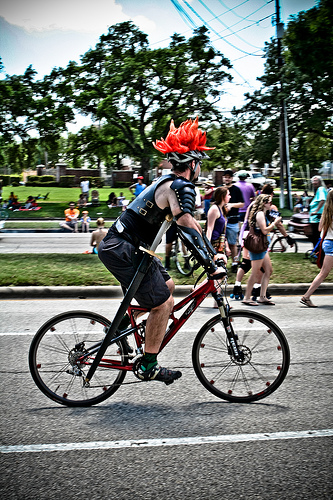


A brown and white dog is carrying a snowball .

3/3 [==============================] - 0s 6ms/step
Значение метрики = 0.3027598261833191


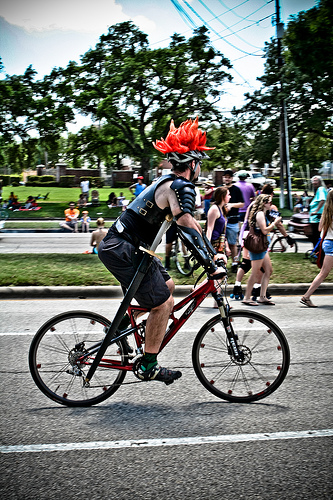


A large gray bird begins to land in the water .

3/3 [==============================] - 0s 3ms/step
Значение метрики = 0.2755212187767029


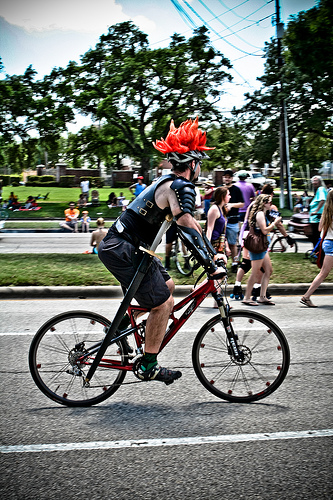


An older dark haired woman is taking a picture

3/3 [==============================] - 0s 6ms/step
Значение метрики = 0.181450754404068


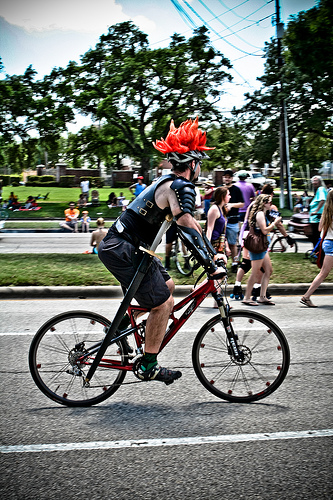


Women play lacrosse .

3/3 [==============================] - 0s 5ms/step
Значение метрики = 0.3054949939250946


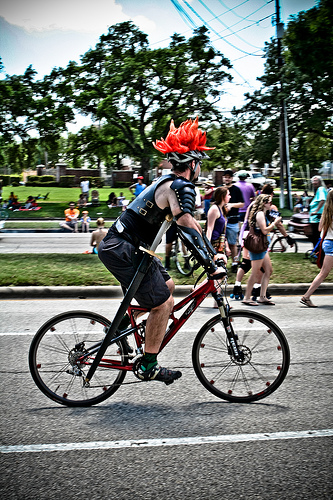


People using an outdoor ice skating rink .

3/3 [==============================] - 0s 3ms/step
Значение метрики = 0.20915091037750244


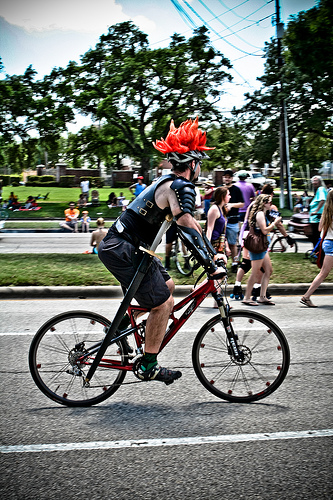


A man in a flowered bathing suit waterskies on one ski while being pulled by a rope .

3/3 [==============================] - 0s 3ms/step
Значение метрики = 0.21543972194194794


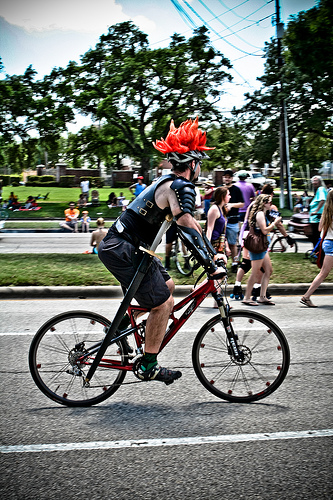


A baby holds a game control above its head and laughs .

3/3 [==============================] - 0s 3ms/step
Значение метрики = 0.23763655126094818


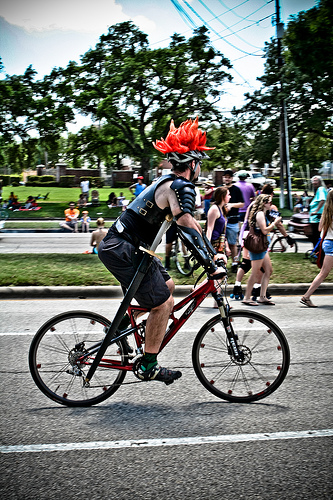


A white dog with brown ears is running on the sidewalk .

3/3 [==============================] - 0s 7ms/step
Значение метрики = 0.3531690239906311


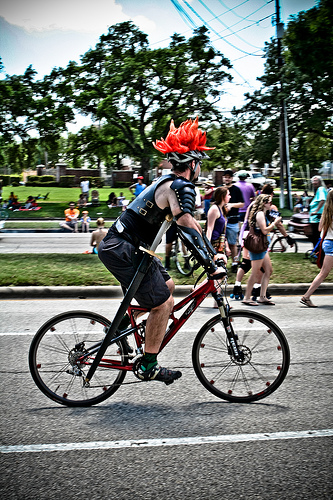


A little white dog in running on the sidewalk .

This image is unavailable in your country in compliance with local laws.
Try another query



In [ ]:
random_rows = test_quer.sample(n=10)
path = DATA_PATH + '/test_images'
with tf.device('/device:GPU:0'):
  for index, row in random_rows.iterrows():
      description = row['query_text']
      generate_image(description, model_lr, lemmatize, count_tf_idf, quer, path)
#generate_image(description, model_lr, lemmatize, count_tf_idf, quer, path)

## Выводы

В данном проекте мы выполнили следующее:
- Проверили предобработку данных, отфильтровали наш датасет по запрещенным словам из запросов
- Обучили модель линейной регрессии и нейронную сеть
- Создали функцию, которая с помощью модели предсказывает на основе описания максимально подходящую фотографию
- С нашим подходом к задаче, функция справляется не лучшим образом и фотографии слабо подходят к запросам